It is a sample notebook for illustration purposes only. We recommend including the below cell with important candidate instructions.
You may need to update the OS and package versions based on the current environment.

### Environment
Ubuntu 22.04 LTS which includes **Python 3.9.12** and utilities *curl*, *git*, *vim*, *unzip*, *wget*, and *zip*. There is no *GPU* support.

The IPython Kernel allows you to execute Python code in the Notebook cell and Python console.

### Installing packages
- Run `!mamba list "package_name"` command to check the package installation status. For example,

```python
!mamba list numpy
"""
# packages in environment at /opt/conda:
#
# Name                    Version                   Build  Channel
numpy                     1.21.6           py39h18676bf_0    conda-forge
"""
```

    You can also try importing the package.

- Run the `!mamba install "package_name"` to install a package

### Excluding large files
HackerRank rejects any submission larger than **20MB**. Therefore, you must exclude any large files by adding these to the *.gitignore* file.
You can **Submit** code to validate the status of your submission.

## Introduction

The Occupational Employment and Wage Statistics (OEWS) program produces employment and wage estimates annually for nearly 800 occupations. These estimates are available for the nation as a whole, for individual states, and for metropolitan and nonmetropolitan areas; national occupational estimates for specific industries are also available.

## Problem

The data used in this problem is a subset of the OEWS data, which include the 10-th percentile, 25-th percentile, 50-th percentile (a.k.a median), 75-th percentile, and 90-th percentile of the annual salary of a given combination of states, industries, and occupations.

One needs to use the data in _train.csv_ to train a machine learning model to predict the 10-th, 25-th, 50-th, 75-th and 90-th percentiles of the given combinations in _submission.csv_.

## Data

### Independent Variables

There are three independent variable columns:
- PRIM_STATE
- NAICS_TITLE
- OCC_TITLE

indicating the state, industry, and occupation.

NOTE:
- In the _PRIM_STATE_ variable, each category indicates a state postal abbreviation (like "_CA_", "_TX_", etc.) or "_U.S_" as the whole United States. When _PRIM_STATE_ is "_U.S_", it means the percentiles are aggregated across all the states.
- In thes _NAICS_TITLE_, each category indicates an industry sector name (like "_Retail Trade_", "_Manufacturing_") or "_Cross-industry_". When _NAICS_TITLE_ is "_Cross-industry_", it means the percentiles are aggregated across all the industries.

### Target Variables

There are 5 dependent (target) variable columns:
- A_PCT10
- A_PCT25
- A_MEDIAN
- A_PCT75
- A_PCT90

indicating the 10-th percentile, 25-th percentile, median, 75-th percentile, 90-th percentile of the annual base salary given the state, industry, and occupation information.

**IMPORTANT**: the percentiles should follow an increasing order. Namely, the 10-th percentile is less than (<) the 25-th percentile, the 25-th percentile is less than (<) the 50-th percentile, etc.

## Deliverables

### Submit a Well commented Jupyter Notebook

Explore the data, make visualizations, and generate new features if required. Make appropriate plots, annotate the notebook with markdowns and explain necessary inferences. A person should be able to read the notebook and understand the steps taken as well as the reasoning behind them. The solution will be graded on the basis of the usage of effective visualizations to convey the analysis and the modeling process.


### Submit _submission.csv_

In the given _submission.csv_, values in the "A_PCT10", "A_PCT25", "A_MEDIAN", "A_PCT75", and "A_PCT90" columns are constants, and you need to replace them with your model predictions.

**IMPORTANT**:
- please do not change the header given in _submission.csv_, or your predictions may not be evaluated correctly.
- Your Jupyter Notebook should be able to generate your submitted predictions.



## Evaluation Metric

The model performance is evaluated by the mean normalized weighted absolute error (MNWAE) defined as the following:
$$ MNWAE = \frac{1}{n} \sum_{i=1}^{n} \sum_{j \in \{10, 25, 50, 75, 90\}} w_j \times \frac{|y_{i,j}-z_{i,j}|}{z_{i,j}}$$
where $y_{i,j}$ and $z_{i,j}$ are the model estimation and the ground truth of the $i$-th row and $j$-th percentile, and
$$ w_{10} = w_{90} = 0.1, $$
$$ w_{25} = w_{75} = 0.2, $$
$$ w_{50} = 0.4 $$

For example, if

actual percentiles = [10000, 30000, 60000, 80000, 100000],

predicted percentiles = [11000, 33000, 54000, 88000, 120000],

normalized weighted absolute error = 0.1*|11000-10000|/10000+0.2*|33000-30000|/30000+0.4*|54000-60000|/60000+0.2*|88000-80000|/80000+0.1*|120000-100000|/100000 = 0.11

**IMPORTANT**: if the predicted percentiles in any row do not follow an increasing order, all the predictions will be considered as invalid.

## Solution ..

Loading the data
----------------

In [234]:
# Import the library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
df_train = pd.read_csv('train.csv')

In [3]:
df_train.head()

,PRIM_STATE,NAICS_TITLE,OCC_TITLE,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90
0,US,"Arts, Entertainment, and Recreation",Supervisors of Transportation and Material Mov...,32350.0,40200.0,50790.0,62560.0,78520.0
1,US,"Mining, Quarrying, and Oil and Gas Extraction","Sales Representatives, Wholesale and Manufactu...",47860.0,61600.0,87810.0,107460.0,153600.0
2,US,Finance and Insurance,Physical Scientists,59240.0,63050.0,89740.0,126320.0,149070.0
3,US,Administrative and Support and Waste Managemen...,"Architects, Surveyors, and Cartographers",37320.0,47630.0,60550.0,77450.0,98990.0
4,US,Manufacturing,Supervisors of Protective Service Workers,50130.0,63840.0,81770.0,104530.0,133180.0


In [4]:
df_train.shape

(2297, 8)

Number of Rows: 2297

Number of Columns: 8

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2297 entries, 0 to 2296
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PRIM_STATE   2297 non-null   object 
 1   NAICS_TITLE  2297 non-null   object 
 2   OCC_TITLE    2297 non-null   object 
 3   A_PCT10      2297 non-null   float64
 4   A_PCT25      2297 non-null   float64
 5   A_MEDIAN     2297 non-null   float64
 6   A_PCT75      2267 non-null   float64
 7   A_PCT90      2158 non-null   float64
dtypes: float64(5), object(3)
memory usage: 143.7+ KB


We got 3 categorical features in the dataset, which need to be converted to numerical data before processing

In [6]:
df_train.describe()

,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90
count,2297.000000,2297.000000,2297.000000,2267.000000,2158.000000
mean,33912.668698,42812.390074,56302.289943,72875.857962,87937.312326
std,13031.997367,18871.177523,27614.004714,36062.506140,39044.025775
min,17080.000000,17290.000000,17940.000000,23780.000000,29740.000000
25%,23910.000000,29360.000000,36750.000000,46840.000000,59492.500000
50%,29780.000000,37310.000000,47860.000000,61730.000000,78005.000000
75%,38280.000000,49320.000000,73050.000000,95695.000000,113310.000000
max,101270.000000,150400.000000,192900.000000,207770.000000,207960.000000


Mean value reflects the order of the value in the feature

i.e., A_PCT10 < A_PCT25 < A_MEDIAN < A_PCT75 < A_PCT90

In [258]:
len(df_train[df_train['PRIM_STATE'] == 'US']), len(df_train[df_train['NAICS_TITLE'] == 'Cross-industry'])

(1498, 885)

Out of 2297 entries, 1498 entries have 'PRIM_STATE' of 'US' i.e the percentiles aggregated across all the state and 885 entries have 'NAICS_TITLE' of 'Cross-industry'.

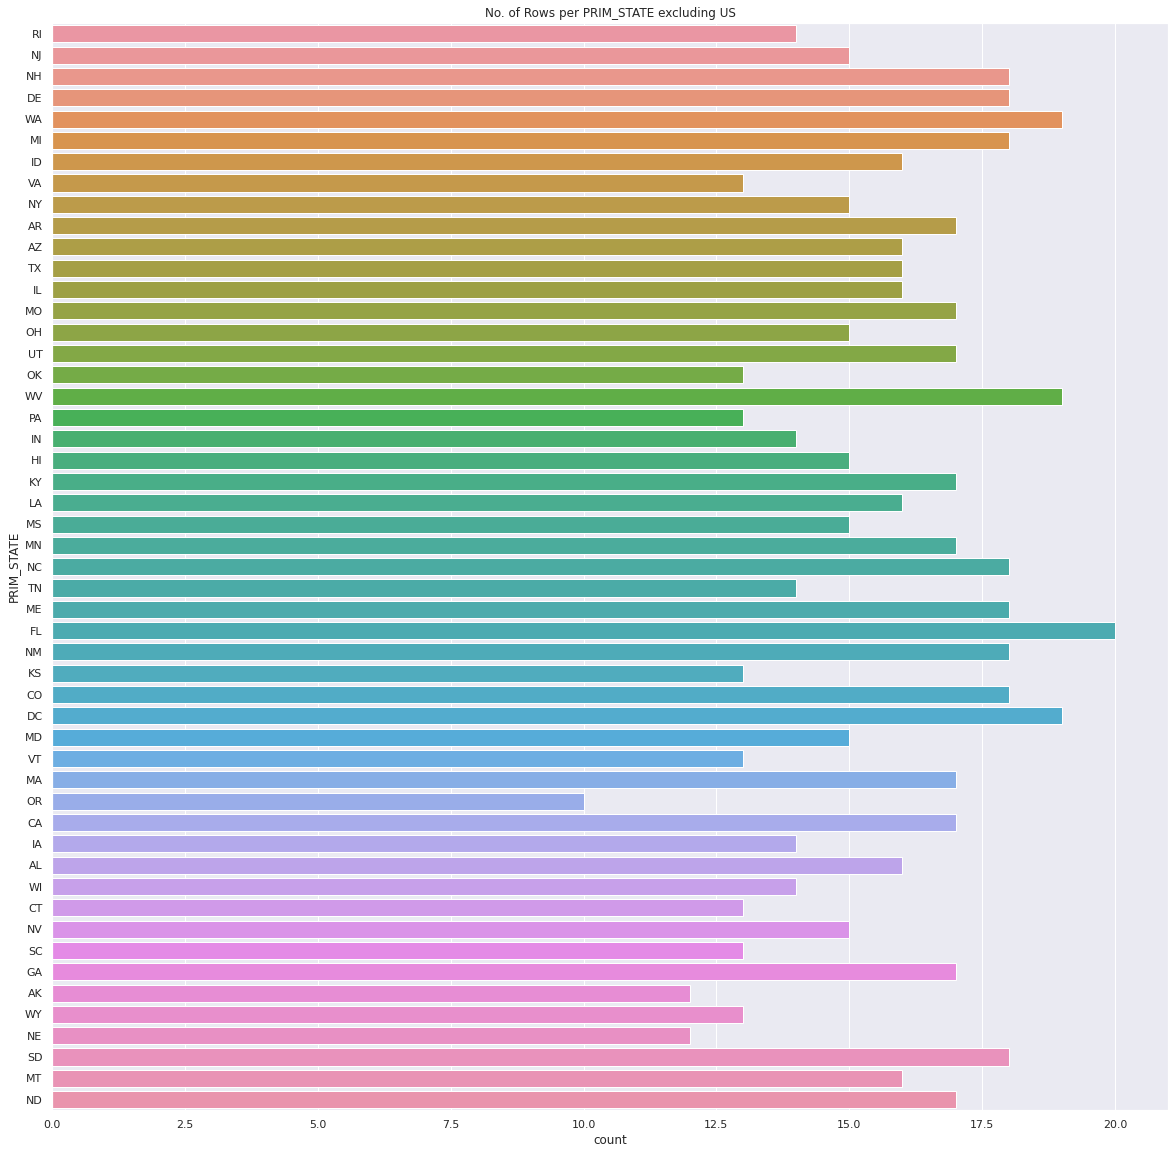

In [251]:
plt.title('No. of Rows per PRIM_STATE excluding US')
sns.set(rc={'figure.figsize':(20,20)})
sns.countplot(y=df_train[df_train['PRIM_STATE'] != 'US'].PRIM_STATE);

As can be seen most of the entries are available for states 'FL', 'WV', 'WA' and 'DC', but the distribution overall is somewhat normal. Similar distribution can be seen for 'NAICS_TITLE' and 'OCC_TITLE'. 

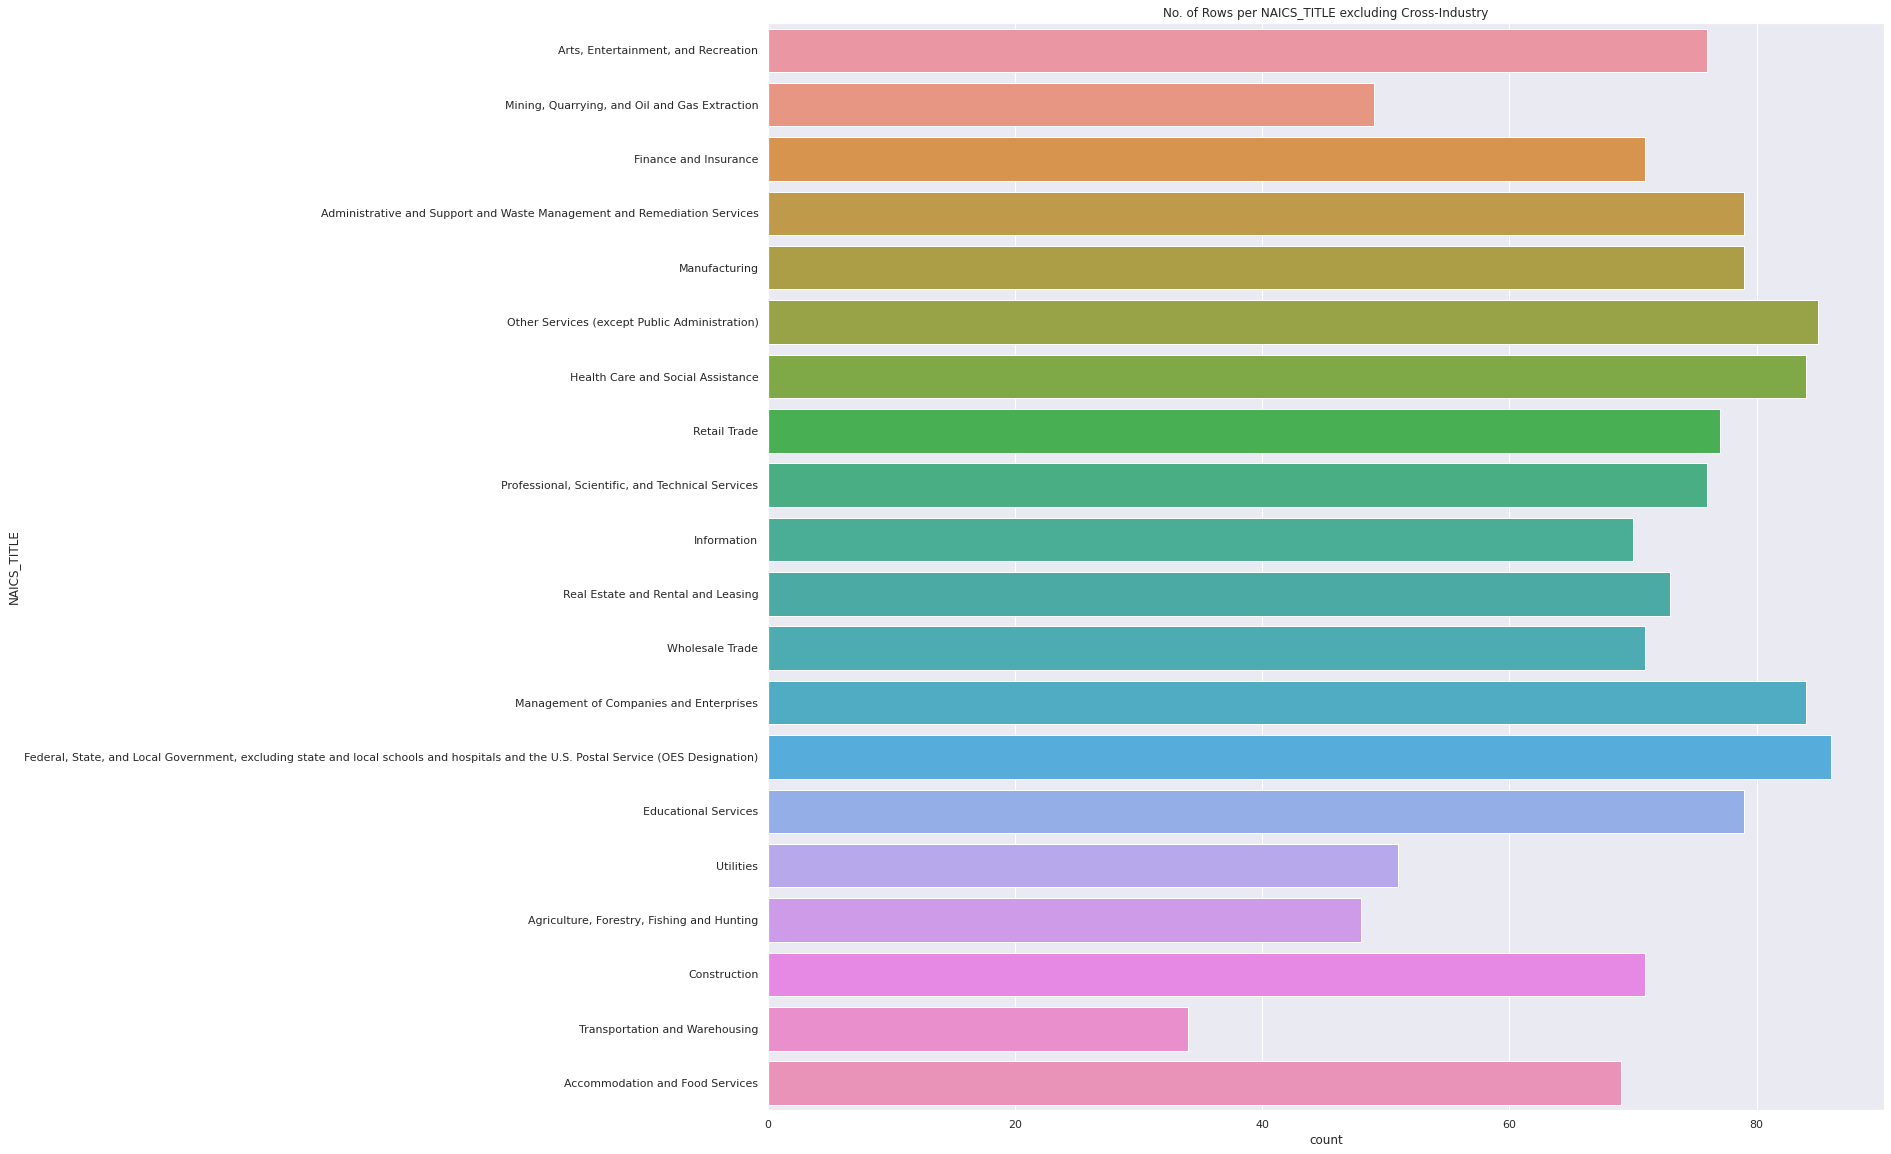

In [257]:
plt.title('No. of Rows per NAICS_TITLE excluding Cross-Industry')
sns.set(rc={'figure.figsize':(20,20)})
sns.countplot(y=df_train[df_train['NAICS_TITLE'] != 'Cross-industry'].NAICS_TITLE);

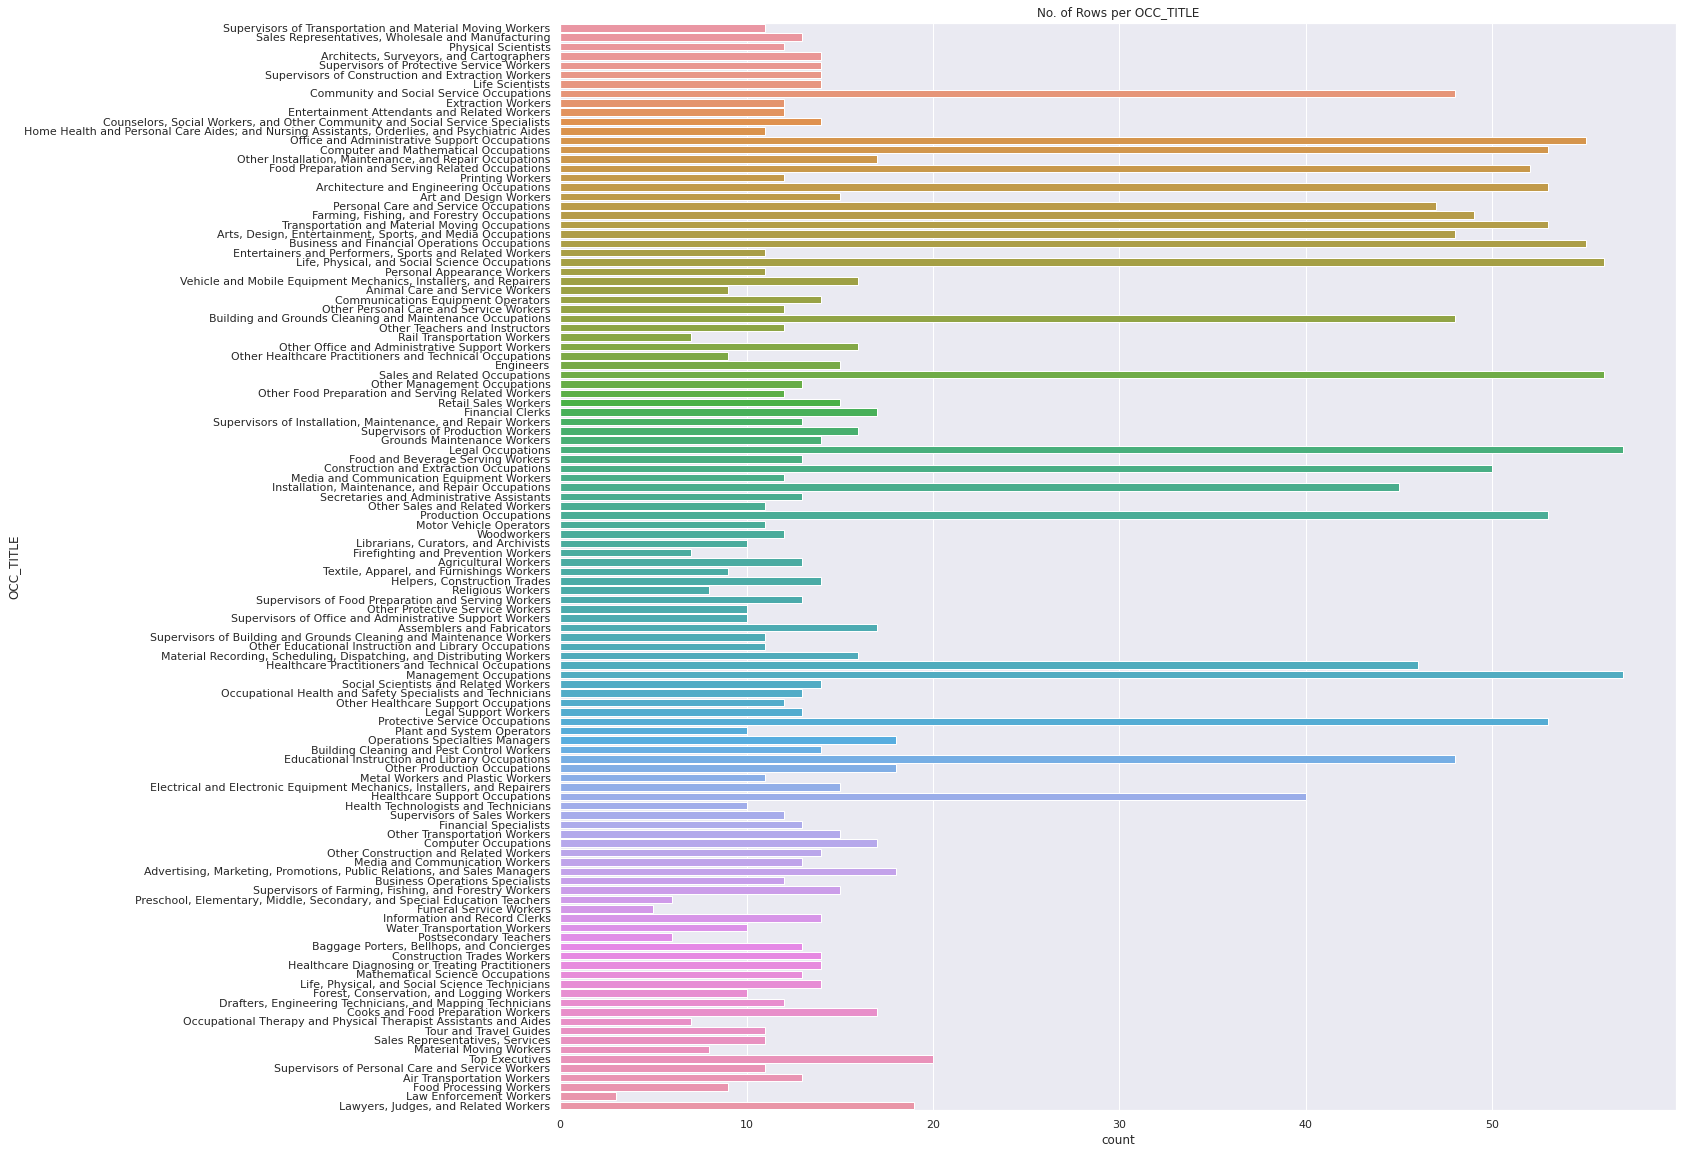

In [254]:
plt.title('No. of Rows per OCC_TITLE')
sns.set(rc={'figure.figsize':(20,20)})
sns.countplot(y=df_train['OCC_TITLE']);

Pre-processing
----------------

Get the attributes and the labels to be predicted from the dataset

In [7]:
attrs = list(df_train.columns)[:3]
labelsList = list(df_train.columns)[3:]
labelsList, attrs

(['A_PCT10', 'A_PCT25', 'A_MEDIAN', 'A_PCT75', 'A_PCT90'],
 ['PRIM_STATE', 'NAICS_TITLE', 'OCC_TITLE'])

In [8]:
#A Dictionary to hold the list of category a feature can have as value 
#and feature name as keys 
uniqueAttr = {}
attrIdx = 0

In [9]:
attrs[attrIdx]

'PRIM_STATE'

Get the unique category that attribute 'PRIM_STATE' can hold

In [10]:
statesList = np.unique(df_train['PRIM_STATE'])
uniqueAttr[attrs[attrIdx]] = statesList
attrIdx += 1
statesList, len(statesList)

(array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
        'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
        'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
        'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
        'US', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], dtype=object),
 52)

Get the unique category that attribute 'NAICS_TITLE' can hold

In [11]:
naicsList = np.unique(df_train['NAICS_TITLE'])
uniqueAttr[attrs[attrIdx]] = naicsList
attrIdx += 1
naicsList, len(naicsList)

(array(['Accommodation and Food Services',
        'Administrative and Support and Waste Management and Remediation Services',
        'Agriculture, Forestry, Fishing and Hunting',
        'Arts, Entertainment, and Recreation', 'Construction',
        'Cross-industry', 'Educational Services',
        'Federal, State, and Local Government, excluding state and local schools and hospitals and the U.S. Postal Service (OES Designation)',
        'Finance and Insurance', 'Health Care and Social Assistance',
        'Information', 'Management of Companies and Enterprises',
        'Manufacturing', 'Mining, Quarrying, and Oil and Gas Extraction',
        'Other Services (except Public Administration)',
        'Professional, Scientific, and Technical Services',
        'Real Estate and Rental and Leasing', 'Retail Trade',
        'Transportation and Warehousing', 'Utilities', 'Wholesale Trade'],
       dtype=object),
 21)

Get the unique category that attribute 'OCC_TITLE' can hold

In [12]:
occList = np.unique(df_train['OCC_TITLE'])
uniqueAttr[attrs[attrIdx]] = occList
attrIdx += 1
occList, len(occList)

(array(['Advertising, Marketing, Promotions, Public Relations, and Sales Managers',
        'Agricultural Workers', 'Air Transportation Workers',
        'Animal Care and Service Workers',
        'Architects, Surveyors, and Cartographers',
        'Architecture and Engineering Occupations',
        'Art and Design Workers',
        'Arts, Design, Entertainment, Sports, and Media Occupations',
        'Assemblers and Fabricators',
        'Baggage Porters, Bellhops, and Concierges',
        'Building Cleaning and Pest Control Workers',
        'Building and Grounds Cleaning and Maintenance Occupations',
        'Business Operations Specialists',
        'Business and Financial Operations Occupations',
        'Communications Equipment Operators',
        'Community and Social Service Occupations', 'Computer Occupations',
        'Computer and Mathematical Occupations',
        'Construction Trades Workers',
        'Construction and Extraction Occupations',
        'Cooks and Food Prep

There are total of 52, 21 and 116 different values that the 3 categorical attributes respectively can have. And since the category are nominal in nature, One-hot or dummies encoding could lead to a total of 189(52+21+116) features compared to the 2297 data presents which is undesirable and so instead would used the binary encoding.

_____________________________
Binary Encoding

In [13]:
def getBinEnc(attrList):
    '''
    Input:
        attrList: List of unique category for a attribute
    Outputs:
        catToBin: Dictionary linking each category to its unique binary encoding
    '''
    #Total categories
    len_ = len(attrList)
    #Number of bit required to encode each category
    n_attr = int(np.ceil(np.log2(len_)))
    #Dictionary linking each category to its unique binary encoding
    catToBin = {}
    
    #loop over all the category and determine the binary encoding correspond to it
    for idx in range(len_):
        binaryEnc = list(map(int, list(bin(idx)[2:])))
        catToBin[attrList[idx]] = [0 for _ in range(n_attr - len(binaryEnc))] + binaryEnc
    
    return catToBin

In [14]:
encodedDf = df_train.copy()

In [15]:
#Binary Encoding for each categorical attributes 
for attr in attrs:
    #get category to binary encoding dictionary
    encDict = getBinEnc(uniqueAttr[attr])
    #get the size of the encoding(Num of Bits required)
    encSize = len(bin(len(uniqueAttr[attr]))[2:])
    
    #For each bits as a column assign a column names
    colName = []
    for idx in range(encSize):
        colName.append(attr + '_' + str(idx))
    
    #Get the corresponding encoding for each data/category in the dataset
    data = []
    for val in df_train[attr]:
        data.append(encDict[val])
    
    #Construct the new DataFrame from the encoded data and the encoded data column names
    tempDf = pd.DataFrame(data, columns=colName)
    #Concate the new dataframe(columns) to the main dataset/dataframe
    encodedDf = pd.concat([encodedDf, tempDf], axis=1)
    #Drop the 'attr' categorical feature/column 
    encodedDf = encodedDf.drop([attr], axis=1)

#Resultant encoded dataset
display(encodedDf.head())

,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,PRIM_STATE_0,PRIM_STATE_1,PRIM_STATE_2,PRIM_STATE_3,PRIM_STATE_4,...,NAICS_TITLE_2,NAICS_TITLE_3,NAICS_TITLE_4,OCC_TITLE_0,OCC_TITLE_1,OCC_TITLE_2,OCC_TITLE_3,OCC_TITLE_4,OCC_TITLE_5,OCC_TITLE_6
0,32350.0,40200.0,50790.0,62560.0,78520.0,1,0,1,1,0,...,0,1,1,1,1,0,1,1,0,0
1,47860.0,61600.0,87810.0,107460.0,153600.0,1,0,1,1,0,...,1,0,1,1,0,1,1,1,1,0
2,59240.0,63050.0,89740.0,126320.0,149070.0,1,0,1,1,0,...,0,0,0,1,0,1,0,0,1,1
3,37320.0,47630.0,60550.0,77450.0,98990.0,1,0,1,1,0,...,0,0,1,0,0,0,0,1,0,0
4,50130.0,63840.0,81770.0,104530.0,133180.0,1,0,1,1,0,...,1,0,0,1,1,0,1,0,1,0


In [122]:
#Divide the encoded dataset into training and target data 
y = encodedDf[labelsList]
X = encodedDf.drop(labelsList, axis=1)

Correlation Matrix, to determine the correlation between each pair of attributes.

In [259]:
corrMat = encodedDf.corr()
corrMat

,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,PRIM_STATE_0,PRIM_STATE_1,PRIM_STATE_2,PRIM_STATE_3,PRIM_STATE_4,...,NAICS_TITLE_2,NAICS_TITLE_3,NAICS_TITLE_4,OCC_TITLE_0,OCC_TITLE_1,OCC_TITLE_2,OCC_TITLE_3,OCC_TITLE_4,OCC_TITLE_5,OCC_TITLE_6
A_PCT10,1.000000,0.965168,0.920309,0.862217,0.770421,0.072054,-0.078577,0.043143,0.140329,-0.064039,...,-0.076902,0.106365,-0.042070,-0.159229,0.130341,0.035297,-0.175509,-0.003865,-0.099118,-0.005247
A_PCT25,0.965168,1.000000,0.969598,0.918847,0.840056,0.063047,-0.072169,0.040705,0.124516,-0.051111,...,-0.064812,0.102786,-0.035291,-0.169675,0.133777,0.052709,-0.182887,0.008479,-0.094823,0.002337
A_MEDIAN,0.920309,0.969598,1.000000,0.968685,0.907105,0.048147,-0.065422,0.026906,0.100188,-0.035075,...,-0.041500,0.084440,-0.024232,-0.168128,0.135843,0.085980,-0.195205,0.009635,-0.087653,0.026230
A_PCT75,0.862217,0.918847,0.968685,1.000000,0.961665,0.010284,-0.041889,-0.001668,0.069166,-0.005086,...,0.011903,0.053094,0.003949,-0.156980,0.114827,0.093232,-0.181511,0.032510,-0.069607,0.072622
A_PCT90,0.770421,0.840056,0.907105,0.961665,1.000000,-0.035203,-0.001074,-0.061292,0.000560,0.031222,...,0.030532,0.035785,0.036542,-0.159210,0.068938,0.121525,-0.120364,0.098103,-0.089241,0.135622
PRIM_STATE_0,0.072054,0.063047,0.048147,0.010284,-0.035203,1.000000,-0.557261,0.426645,0.417799,-0.465192,...,-0.400039,0.352778,-0.375250,0.111646,0.048792,-0.079678,0.032652,0.007067,0.030525,-0.196500
PRIM_STATE_1,-0.078577,-0.072169,-0.065422,-0.041889,-0.001074,-0.557261,1.000000,-0.428151,-0.412113,0.358982,...,0.300799,-0.265262,0.282159,-0.090374,-0.040362,0.040847,-0.002646,-0.009141,-0.017016,0.148576
PRIM_STATE_2,0.043143,0.040705,0.026906,-0.001668,-0.061292,0.426645,-0.428151,1.000000,0.465917,-0.419963,...,-0.359792,0.317286,-0.337497,0.105908,0.043329,-0.063538,0.035755,0.002635,0.020848,-0.199087
PRIM_STATE_3,0.140329,0.124516,0.100188,0.069166,0.000560,0.417799,-0.412113,0.465917,1.000000,-0.415293,...,-0.365881,0.322655,-0.343208,0.103912,0.053869,-0.063076,0.025779,-0.000518,0.030724,-0.203449
PRIM_STATE_4,-0.064039,-0.051111,-0.035075,-0.005086,0.031222,-0.465192,0.358982,-0.419963,-0.415293,1.000000,...,0.344456,-0.303762,0.323111,-0.081911,-0.060064,0.060261,-0.025150,-0.007398,-0.051234,0.197313


As can be seen, A_PCT10, A_PCT25, MEDIAN, A_PCT75, A_PCT90 have correlation of more than 0.75 which satisfied the definition of the attributes.

In [266]:
corrMat['A_MEDIAN']

A_PCT10          0.920309
A_PCT25          0.969598
A_MEDIAN         1.000000
A_PCT75          0.968685
A_PCT90          0.907105
PRIM_STATE_0     0.048147
PRIM_STATE_1    -0.065422
PRIM_STATE_2     0.026906
PRIM_STATE_3     0.100188
PRIM_STATE_4    -0.035075
PRIM_STATE_5    -0.057607
NAICS_TITLE_0    0.042920
NAICS_TITLE_1    0.150918
NAICS_TITLE_2   -0.041500
NAICS_TITLE_3    0.084440
NAICS_TITLE_4   -0.024232
OCC_TITLE_0     -0.168128
OCC_TITLE_1      0.135843
OCC_TITLE_2      0.085980
OCC_TITLE_3     -0.195205
OCC_TITLE_4      0.009635
OCC_TITLE_5     -0.087653
OCC_TITLE_6      0.026230
Name: A_MEDIAN, dtype: float64

Comparing all the features with that of target features(or just comparing with A_MEDIAN) we get no features having correlation greater than 0.15(i.e., training features have very less dependency on target features)

Missing Value Treatment
-----------------------

In [123]:
#Check if any target attributes contains null
np.sum(y.isnull())

A_PCT10       0
A_PCT25       0
A_MEDIAN      0
A_PCT75      30
A_PCT90     139
dtype: int64

Target attributes 'A_PCT75' and 'A_PCT90' contains 30 and 139 respectively null value. And so it requires a missing value treatment.  

In [124]:
#Getting the missing value indices
attr90MissIndex = list(y[y.isnull()['A_PCT90']].index)
attr75MissIndex = list(y[y.isnull()['A_PCT75']].index)
len(attr75MissIndex), len(attr90MissIndex)

(30, 139)

As we have a clear pattern where A_PCT90 > A_PCT75 > MEDIAN > A_PCT25 > A_PCT10
- Using a constant value(Min , Max, Mean, Mode) to replaced the null value would lead to inconsistency.
- Again can't remove the whole row from training as number of instances are very small, and so removing a row would lead to further loss of Information

In that case, we would be using regression technique to predict the missing value

In [125]:
#Get the training and test data
#Test data are the instances that contains the null value

#Get the training and test data for A_PCT75
testdf75 = encodedDf[encodedDf['A_PCT75'].isnull()==True]
traindf75 = encodedDf[encodedDf['A_PCT75'].isnull()==False]

#Get the training and test data for A_PCT90
testdf90 = encodedDf[encodedDf['A_PCT90'].isnull()==True]
traindf90 = encodedDf[encodedDf['A_PCT90'].isnull()==False]

testdf75.shape, traindf75.shape, testdf90.shape, traindf90.shape

((30, 23), (2267, 23), (139, 23), (2158, 23))

In [126]:
#Predicting the missing value using linear regression
from sklearn.linear_model import LinearRegression

#predicting missing value in attributes 'A_PCT75'
lr75 = LinearRegression()

y75 = traindf75['A_PCT75']
traindf75.drop(['A_PCT75', 'A_PCT90'],axis=1,inplace=True)

#Training the model
lr75.fit(traindf75, y75)

testdf75.drop(['A_PCT75', 'A_PCT90'],axis=1,inplace=True)

#Get the missing A_PCT75 value
pred75 = lr75.predict(testdf75)

/tmp/ipykernel_193480/3544258349.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traindf75.drop(['A_PCT75', 'A_PCT90'],axis=1,inplace=True)
/tmp/ipykernel_193480/3544258349.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdf75.drop(['A_PCT75', 'A_PCT90'],axis=1,inplace=True)


In [127]:
#predicting missing value in attributes 'A_PCT90'
lr90 = LinearRegression()

y90 = traindf90['A_PCT90']
traindf90.drop(['A_PCT75', 'A_PCT90'],axis=1,inplace=True)

#Training the model
lr90.fit(traindf90, y90)
testdf90.drop(['A_PCT75', 'A_PCT90'],axis=1,inplace=True)

#Get the missing A_PCT90 value
pred90 = lr90.predict(testdf90)

/tmp/ipykernel_193480/3732574707.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traindf90.drop(['A_PCT75', 'A_PCT90'],axis=1,inplace=True)
/tmp/ipykernel_193480/3732574707.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdf90.drop(['A_PCT75', 'A_PCT90'],axis=1,inplace=True)


In [128]:
#Insert the missing value to its respective places
y.loc[attr75MissIndex, 'A_PCT75'] = pred75
y.loc[attr90MissIndex, 'A_PCT90'] = pred90

/tmp/ipykernel_193480/681285171.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[attr75MissIndex, 'A_PCT75'] = pred75
/tmp/ipykernel_193480/681285171.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[attr90MissIndex, 'A_PCT90'] = pred90


In [129]:
y

,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90
0,32350.0,40200.0,50790.0,62560.000000,78520.000000
1,47860.0,61600.0,87810.0,107460.000000,153600.000000
2,59240.0,63050.0,89740.0,126320.000000,149070.000000
3,37320.0,47630.0,60550.0,77450.000000,98990.000000
4,50130.0,63840.0,81770.0,104530.000000,133180.000000
...,...,...,...,...,...
2292,47950.0,73720.0,101550.0,163990.000000,175128.455707
2293,47580.0,75920.0,126220.0,183439.919334,235208.047001
2294,46400.0,60560.0,98070.0,161120.000000,180193.899228
2295,37540.0,51260.0,80850.0,135490.000000,148572.261266


Training and Determining the Best Model
---------------------------------------

Dividing the dataset into training and test set

In [130]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=23)

To get the best model, multiple State-Of-The-Art model is trained and tested on the test set. The best model is choosen based on the test set and overall dataset score.

To score the model, mean normalized weighted absolute error(MNWAE) is used.

In [224]:
#Dictionary to get the test score for each model as value,
#given the model name as keys
modelScore = {}

1. LINEAR REGRESSION

In [131]:
#Using Linear Regression to predict the percentile
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)

LinearRegression()

Defining the mean normalized weighted absolute error(MNWAE) to determine the score of a model

In [175]:
def MNWAE(model, xtest, ytest):
    '''
    Inputs:
        model- trained machine learning model
        xtest- attributes used to predict the labels
        ytest- labels to be predicted
    Output:
        score: mean normalized weighted absolute error
    '''
    #Get the num of rows and columns in the labels
    n = ytest.shape[0]
    m = ytest.shape[1]
    
    #Predict the labels
    ypred = model.predict(xtest)

    #Weight assigned to each label
    wt = [0.1, 0.2, 0.4, 0.2, 0.1]
    #Initialized the score to 0
    score = 0
    #for each label
    for j in range(m):
        #for each instances
        for i in range(n):
            #Get the normalized weighted absolute difference for each element  
            eleScore = wt[j]*abs(ytest.iloc[i, j] - ypred[i][j])
            score += eleScore/ytest.iloc[i, j]
    #Divided by 'n' to get the mean score
    score = score/n

    return score

In [225]:
#MNWAE score for linear regression model
score = MNWAE(linearModel, X_test, y_test)
modelScore['Linear Regression'] = score
score

0.4288688638146917

In [177]:
#MNWAE Score of Linear Regression on the whole datasets
MNWAE(linearModel, X, y)

0.38184951960924784

Linear Regression gives an MNWAE score of 0.429 and 0.382 for test set and whole dataset respectively

2. K-NEIGHBORS REGRESSOR

In [146]:
#Using k-nearest neighbors to predict the percentile
from sklearn.neighbors import KNeighborsRegressor

knnModel = KNeighborsRegressor()
knnModel.fit(X_train, y_train)

KNeighborsRegressor()

In [226]:
#MNWAE test score for K Neighbors Regressor model
score = MNWAE(knnModel, X_test, y_test)
modelScore['KNN Regressor'] = score
score

0.3033624364519542

In [179]:
#Accuracy of K-Nearest Neighbors Model on the whole datasets
MNWAE(knnModel, X, y)

0.21978929101552616

K-Neighbors RFegressor gives an MNWAE score of 0.303 and 0.219 for test set and whole dataset respectively

3. DECISION TREE

In [151]:
#Using decision tree regressor to predict the percentile
from sklearn.tree import DecisionTreeRegressor

treeModel = DecisionTreeRegressor()
treeModel.fit(X_train, y_train)

DecisionTreeRegressor()

In [227]:
#MNWAE test score for Decision Tree model
score = MNWAE(treeModel, X_test, y_test)
modelScore['Decision Tree'] = score
score

0.1991261844126319

In [181]:
#Accuracy of Decision Tree on the whole datasets
MNWAE(treeModel, X, y)

0.019938625343885658

Decision tree regressor gives an MNWAE score of 0.199 and 0.019 for test set and whole dataset respectively

4. SUPPORT VECTOR MACHINE

In [154]:
#Using SVM to predict the percentile
from sklearn.svm import LinearSVR
from sklearn.multioutput import MultiOutputRegressor

svmModel = LinearSVR()
#As SVM can be used to determine only one labels, 
#MultiOutputRegressor is used to get multiple SVM model to determone multiple labels
svmWrapper = MultiOutputRegressor(svmModel)
svmWrapper.fit(X_train, y_train)

MultiOutputRegressor(estimator=LinearSVR())

In [228]:
#MNWAE test score for SVM model
score = MNWAE(svmWrapper, X_test, y_test)
modelScore['SVM'] = score
score

0.7484346104233752

In [183]:
#Accuracy of SVM on the whole datasets
MNWAE(svmWrapper, X, y)

0.7462196692748101

SVM gives an MNWAE score of 0.748 and 0.746 for test set and whole dataset respectively

5. Neural Network Model (2 hidden state of 32 and 16)

In [75]:
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
import tensorflow as tf

In [161]:
# get the model
def get_nn_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(32, input_shape=(n_inputs,), activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(n_outputs))
    model.compile(loss='mae', optimizer='adam')
    return model
 

In [162]:
# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
    results = list()
    n_inputs, n_outputs = X.shape[1], y.shape[1]
    # define evaluation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=23)
    
    # enumerate folds
    for train_idx, test_idx in cv.split(X):
        # prepare data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        # define model
        model = get_nn_model(n_inputs, n_outputs)
        # fit model
        model.fit(X_train, y_train, epochs=100, verbose=0, batch_size=32)
        # evaluate model on test set
        mae = model.evaluate(X_test, y_test)
        # store result
        print('>%.3f' % mae)
        results.append(mae)
    
    return model, results

In [163]:
nn_model, results = evaluate_model(X, y)

8/8 [==============================] - 0s 1ms/step - loss: 23550.9004
>23550.900
8/8 [==============================] - 0s 2ms/step - loss: 19414.4785
>19414.479
8/8 [==============================] - 0s 2ms/step - loss: 19658.4453
>19658.445
8/8 [==============================] - 0s 2ms/step - loss: 23094.0078
>23094.008
8/8 [==============================] - 0s 2ms/step - loss: 22159.6348
>22159.635
8/8 [==============================] - 0s 2ms/step - loss: 19773.8301
>19773.830
8/8 [==============================] - 0s 1ms/step - loss: 21258.6152
>21258.615
8/8 [==============================] - 0s 2ms/step - loss: 21725.3379
>21725.338
8/8 [==============================] - 0s 2ms/step - loss: 22080.6074
>22080.607
8/8 [==============================] - 0s 2ms/step - loss: 22164.9082
>22164.908
8/8 [==============================] - 0s 2ms/step - loss: 21378.7148
>21378.715
8/8 [==============================] - 0s 2ms/step - loss: 23101.7637
>23101.764
8/8 [=======================

In [229]:
#Accuracy of Neural Network on the test datasets
score = MNWAE(nn_model, X_test, y_test)
modelScore['Neural Network'] = score
score

0.35493875398059777

In [185]:
#Accuracy of Neural Network on the whole datasets
MNWAE(nn_model, X, y)

0.3338881088381924

Neural Network gives an MNWAE score of 0.355 and 0.334 for test set and whole dataset respectively

_______________________________
Comparing the different models

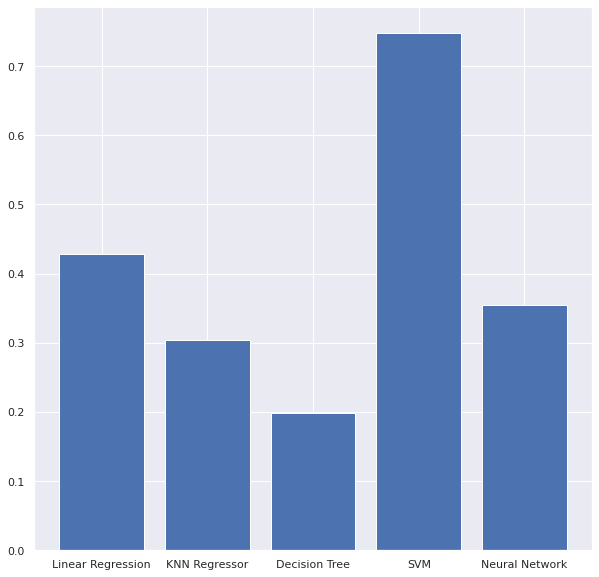

In [272]:
names = list(modelScore.keys())
values = list(modelScore.values())

plt.figure(figsize=(10,10)) 
plt.bar(range(len(names)), values, tick_label=names)
plt.show()

In [231]:
modelScore

{'Linear Regression': 0.4288688638146917,
 'KNN Regressor': 0.3033624364519542,
 'Decision Tree': 0.1991261844126319,
 'SVM': 0.7484346104233752,
 'Neural Network': 0.35493875398059777}

It can be seen, as lower the score, better the result

Decision Tree > KNN Regressor > Neural Network > Linear Regression > SVM

Decision Tree works better compared to other models.

Improving the decision tree model
--------------------------------

One way can improve the model is by using ensemble model. 

That is by using two models:
    
    1. Random Forest Regressor
    2. Extreme Gradient Boosting Regressor

In [187]:
from sklearn.ensemble import RandomForestRegressor

rdmForest = RandomForestRegressor(random_state=23)

rdmForest.fit(X_train, y_train)

RandomForestRegressor(random_state=23)

In [189]:
#Accuracy of Random Forest on the test datasets
MNWAE(rdmForest, X_test, y_test)

0.17805944452358585

In [190]:
#Accuracy of Random Forest on the whole datasets
MNWAE(rdmForest, X, y)

0.07962397813542467

Using Random Forest we are able to improve the score from 0.199 to 0.178

In [191]:
from xgboost import XGBRegressor

/opt/conda/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [193]:
xgbModel = XGBRegressor(random_state=23)

xgbWrapper = MultiOutputRegressor(xgbModel)
xgbWrapper.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            enable_categorical=False,
                                            gamma=None, gpu_id=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=23,
                                            reg_alpha=None, reg_lambda=None,
                                            scale_pos_weight=None,
                                            subsample=None, tree_method=None,
                                            validate_parameters=None,
                                            verbosity=None))

In [194]:
#Accuracy of XGB Regressor on the test datasets
MNWAE(xgbWrapper, X_test, y_test)

0.19809368457678245

In [195]:
#Accuracy of XGB Regressor on the whole datasets
MNWAE(xgbWrapper, X, y)

0.0981103641401014

Using xgb Regressor we are able to improve the score from 0.199 to 0.198

Of all the model that is being used, Random Forest comparitively able to predict the data better. 


______________
Based on the Random forest, we can determine the importance of an attributes to that of target.

In [304]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rdmForest.feature_importances_
}).sort_values('importance', ascending=False)

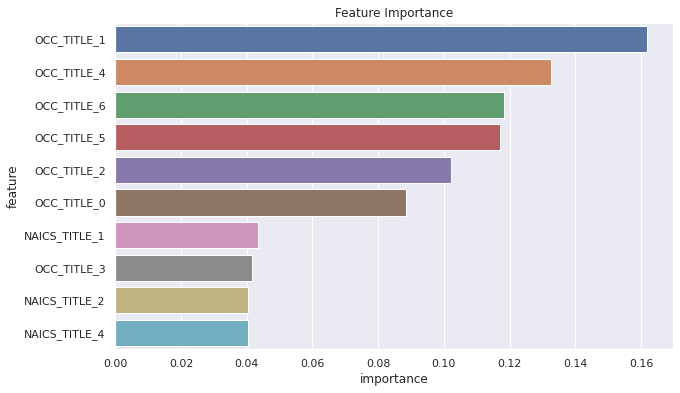

In [305]:
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

Looking into the top 10 important features, it can be seen that the wages(target features) are comparitively largely dependent/correlate to 'OCC_TITLE' or occupation

_______________________________________________________________
Now the objective is to how to further improved the Random Forest Model

Instead of dividing the whole dataset into training and test datasets, We can use KFold and use the whole dataset for training

In [196]:
from sklearn.model_selection import KFold

Get the improved model and MNWAE Score w.r.t the parameter set

In [197]:
def train_and_evaluate(X_train, y_train, X_val, y_val, **params):
    '''
    Inputs:
        X_train- Training features data
        y_train- Training target data
        X_val- Validation feature data
        y_val- Validation target data
        **param- set  of parameter to be used with RandomForestRegressor
    Outputs:
        model- Random Forest model
        train_score- MNWAE Score for training dataset
        val_score- MNWAE Score for validation dataset
    '''
    model = RandomForestRegressor(random_state=23, n_jobs=-1, **params)
    model.fit(X_train, y_train)
    train_score = MNWAE(model, X_train, y_train)
    val_score = MNWAE(model, X_val, y_val)
    return model, train_score, val_score

In [198]:
def test_params_kfold(n_splits, **params):
    '''
    Inputs:
        n_splits- Number of Folds
        **params- Set of parameter to be used with Random Forest
    Outputs:
        np.mean(train_score_list)- Mean MNWAE Score for training set
        np.mean(val_score_list)- Mean MNWAE Score for Validation set
        models- Improved Random Forest Model
    '''
    
    train_score_list, val_score_list, models = [], [], []
    kfold = KFold(n_splits)
    #Split dataset into 'n_splits' consecutive folds
    for train_idxs, val_idxs in kfold.split(X):
        #Determine the training and test features and targets
        X_train, train_targets = X.iloc[train_idxs], y.iloc[train_idxs]
        X_val, val_targets = X.iloc[val_idxs], y.iloc[val_idxs]
        #Get score and model for each folds
        model, train_score, val_score = train_and_evaluate(X_train, train_targets, X_val, val_targets, **params)
        #Appending the score and model into a list
        models.append(model)
        train_score_list.append(train_score)
        val_score_list.append(val_score)
    #Get the mean Score from thge list
    print('Train SCORE: {}, Validation SCORE: {}'.format(np.mean(train_score_list), np.mean(val_score_list)))
    return np.mean(train_score_list), np.mean(val_score_list), models

In [214]:
test_params_kfold(10)

Train SCORE: 0.06855698247934318, Validation SCORE: 0.1922652232037167


(0.06855698247934318,
 0.1922652232037167,
 [RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23)])

In [275]:
test_params_kfold(20)

Train SCORE: 0.06764110222033021, Validation SCORE: 0.1876410629741897


(0.06764110222033021,
 0.1876410629741897,
 [RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  R

In [278]:
test_params_kfold(25)

Train SCORE: 0.06789718445340573, Validation SCORE: 0.18468642898918142


(0.06789718445340573,
 0.18468642898918142,
 [RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  

In [276]:
test_params_kfold(30)

Train SCORE: 0.06759416824362766, Validation SCORE: 0.18348375832882227


(0.06759416824362766,
 0.18348375832882227,
 [RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  

In [279]:
test_params_kfold(35)

Train SCORE: 0.0673420374132098, Validation SCORE: 0.18433047018590046


(0.0673420374132098,
 0.18433047018590046,
 [RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  RandomForestRegressor(n_jobs=-1, random_state=23),
  R

Splitting dataset into 30 folds gives us the best score of 0.183

_________________________________
For each parameter, determining the optimal parameter value.

In [280]:
def test_param_and_plot_gbm(n_splits, param_name, param_values, **params):
    '''
    Inputs:
        n_splits- Number of folds 
        param_name- Parameter Name
        param_values- List of Parameter values to be used with parameter name
        **params- Set of parameter to be used with Random Forest
    Plot the graph of score obtained for each param_values
    '''
    train_errors, val_errors = [], [] 
    #for each value in parameter values added with the set of params 
    #obtained the validation score 
    for value in param_values:
        newparams = {param_name: value}
        for para in params:
          newparams[para] = params[para]
        train_score, val_score, model = test_params_kfold(n_splits, **newparams)
        train_errors.append(train_score)
        val_errors.append(val_score)
    print(val_errors)
    #plot the graph
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('MNWAE')
    plt.legend(['Training', 'Validation'])

Train SCORE: 0.06876995748360495, Validation SCORE: 0.1850813602217788
Train SCORE: 0.06715086773623373, Validation SCORE: 0.1830942197372289
Train SCORE: 0.06661570511826916, Validation SCORE: 0.18277376786784305
Train SCORE: 0.06666761508188647, Validation SCORE: 0.18302655888074773
Train SCORE: 0.06652706732510598, Validation SCORE: 0.1827947243296115
[0.1850813602217788, 0.1830942197372289, 0.18277376786784305, 0.18302655888074773, 0.1827947243296115]


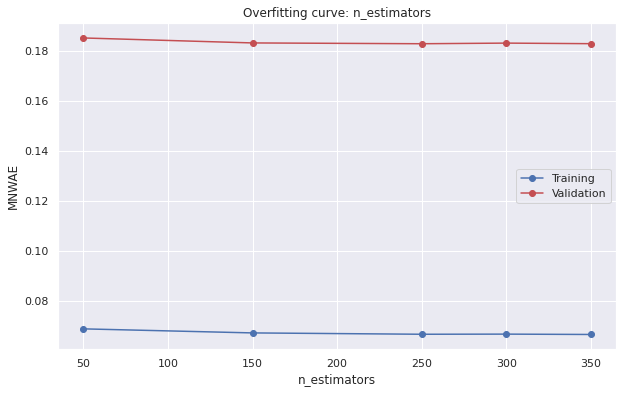

In [288]:
test_param_and_plot_gbm(30, 'n_estimators', [50, 150, 250, 300, 350])

As per above graph, Higher the n_estimators the better the result we are getting.
Hence optimal parameter would be n_estimators = 250. 
Giving us the score of 0.18277 from 0.183

Train SCORE: 0.38816725737368746, Validation SCORE: 0.3930148522925211
Train SCORE: 0.3128013058887008, Validation SCORE: 0.3226577359784597
Train SCORE: 0.22431539387936725, Validation SCORE: 0.24453593125779446
Train SCORE: 0.14359905677264528, Validation SCORE: 0.1882568420424248
Train SCORE: 0.09739290637676248, Validation SCORE: 0.17988277171904893
Train SCORE: 0.07708188253475191, Validation SCORE: 0.18155762216674348
Train SCORE: 0.06737560745046277, Validation SCORE: 0.18254577370984545
[0.3930148522925211, 0.3226577359784597, 0.24453593125779446, 0.1882568420424248, 0.17988277171904893, 0.18155762216674348, 0.18254577370984545]


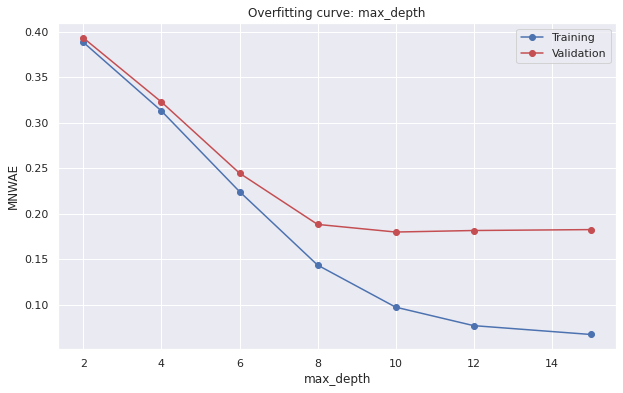

In [284]:
test_param_and_plot_gbm(30, 'max_depth', [2, 4, 6, 8, 10, 12, 15], n_estimators = 250)

As per above graph, Higher the max_depth the better the result but after a certain point overfitting is observed.
Hence optimal parameter would be max_depth = 10.

Improving the score from 0.18277 to 0.17988

Train SCORE: 0.09739290637676248, Validation SCORE: 0.17988277171904893
Train SCORE: 0.10628948651636327, Validation SCORE: 0.18045293087990552
Train SCORE: 0.12395919427691164, Validation SCORE: 0.18136915792631556
Train SCORE: 0.15229755891289842, Validation SCORE: 0.1922950681161346
Train SCORE: 0.17014716344045228, Validation SCORE: 0.20283819049593976
[0.17988277171904893, 0.18045293087990552, 0.18136915792631556, 0.1922950681161346, 0.20283819049593976]


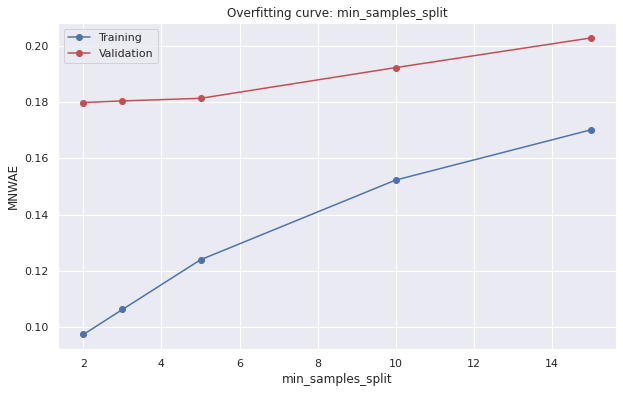

In [285]:
test_param_and_plot_gbm(30, 'min_samples_split', [2, 3, 5, 10, 15], max_depth = 10, n_estimators = 250)

Here, the lower the min_samples_split better the result. Optimal value of min_samples_split = 2 which is the by default value. 

Train SCORE: 0.21555815371625228, Validation SCORE: 0.2987854931364172
Train SCORE: 0.18200425066302148, Validation SCORE: 0.2635345853245546
Train SCORE: 0.15072014895681232, Validation SCORE: 0.23211585754268274
Train SCORE: 0.12929457793610408, Validation SCORE: 0.21150718793054113
Train SCORE: 0.11268557609973198, Validation SCORE: 0.19527513087545348
Train SCORE: 0.1008526760188277, Validation SCORE: 0.18326765922664007
Train SCORE: 0.09739290637676248, Validation SCORE: 0.17988277171904893
[0.2987854931364172, 0.2635345853245546, 0.23211585754268274, 0.21150718793054113, 0.19527513087545348, 0.18326765922664007, 0.17988277171904893]


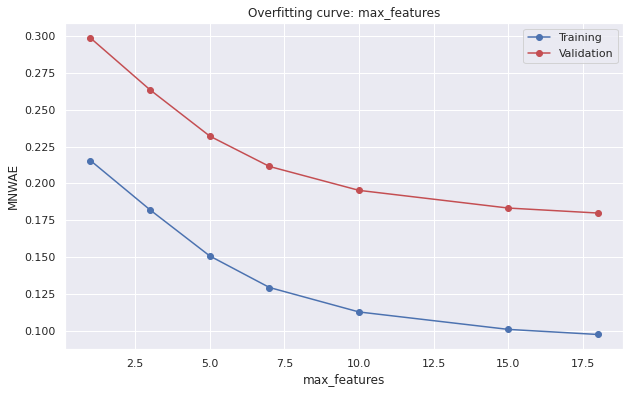

In [286]:
test_param_and_plot_gbm(30, 'max_features', [1, 3, 5, 7, 10, 15, 18], n_estimators = 250, max_depth = 10, min_samples_split = 2)

More the features that is to be considered when considering the split, the better the result.

Train SCORE: 0.17477600800437657, Validation SCORE: 0.20088061437517257
Train SCORE: 0.13895995826330332, Validation SCORE: 0.18278702655349346
Train SCORE: 0.12199808412211205, Validation SCORE: 0.17944511220011083
Train SCORE: 0.11151572776119156, Validation SCORE: 0.17888388306547298
Train SCORE: 0.10444758691009115, Validation SCORE: 0.17906064593169593
[0.20088061437517257, 0.18278702655349346, 0.17944511220011083, 0.17888388306547298, 0.17906064593169593]


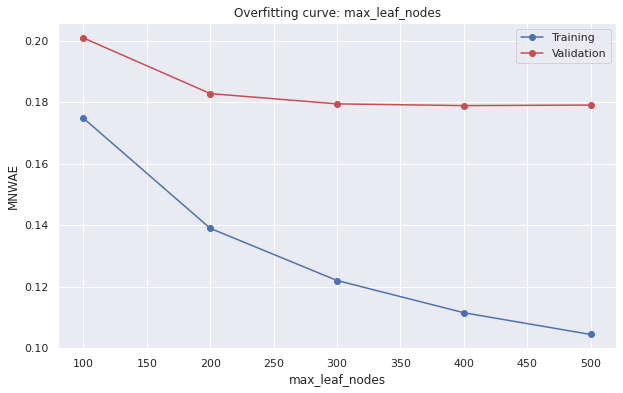

In [295]:
test_param_and_plot_gbm(30, 'max_leaf_nodes', [100, 200, 300, 400, 500], n_estimators = 250, max_depth = 10, min_samples_split = 2)

Here, we get the optimal value of max_leaf_nodes = 400 which improves the score from 0.17988 to 0.17888

Train SCORE: 0.11151572776119155, Validation SCORE: 0.17888388306547298
Train SCORE: 0.11179428446708548, Validation SCORE: 0.19738624946344724
[0.17888388306547298, 0.19738624946344724]


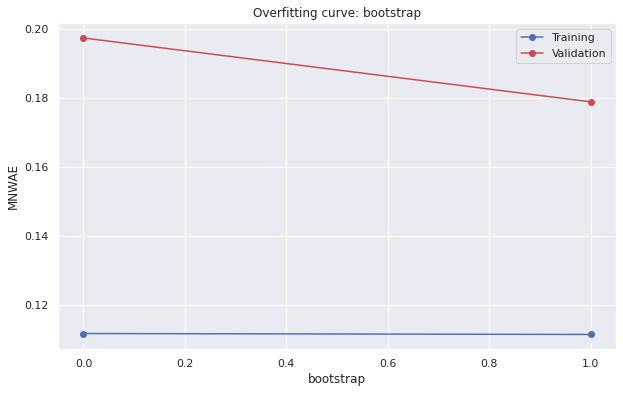

In [306]:
test_param_and_plot_gbm(30, 'bootstrap', [True, False], max_leaf_nodes = 400, n_estimators = 250, max_depth = 10, min_samples_split = 2)

With bootstrap = True give comparitively better result, which is the default setting 

Putting it all together

In [308]:
final_train_score, final_val_score, final_models = test_params_kfold(30,
                                                                     n_estimators = 250, 
                                                                     max_depth = 10,  
                                                                     min_samples_split = 2, 
                                                                     max_leaf_nodes = 400)

Train SCORE: 0.11151572776119158, Validation SCORE: 0.17888388306547298


Predicting Data
---------------

In [309]:
#As k-fold is used, multiple model is present
#Predicted Values afre the mean of predicted values for each model
def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [310]:
df_submission = pd.read_csv('submission.csv')

In [312]:
df_submission.head()

,PRIM_STATE,NAICS_TITLE,OCC_TITLE,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90
0,US,Accommodation and Food Services,Other Production Occupations,10000,20000,30000,40000,50000
1,NE,Cross-industry,"Arts, Design, Entertainment, Sports, and Media...",10000,20000,30000,40000,50000
2,US,Manufacturing,Construction and Extraction Occupations,10000,20000,30000,40000,50000
3,US,Wholesale Trade,Material Moving Workers,10000,20000,30000,40000,50000
4,US,Other Services (except Public Administration),Supervisors of Building and Grounds Cleaning a...,10000,20000,30000,40000,50000


In [313]:
df_submission.shape

(926, 8)

Submission data has 926 rows

In [314]:
encodedSubDf = df_submission.copy()

Pre-processing the submission data, so it can be used with the final model to predict the target features

In [317]:
#Binary Encoding for each categorical attributes in submission df
for attr in attrs:
    #get category to binary encoding dictionary
    encDict = getBinEnc(uniqueAttr[attr])
    #get the size of the encoding(Num of Bits required)
    encSize = len(bin(len(uniqueAttr[attr]))[2:])
    
    #For each bits as a column assign a column names
    colName = []
    for idx in range(encSize):
        colName.append(attr + '_' + str(idx))
    
    #Get the corresponding encoding for each data/category in the dataset
    data = []
    for val in df_submission[attr]:
        data.append(encDict[val])
    
    #Construct the new DataFrame from the encoded data and the encoded data column names
    tempSubDf = pd.DataFrame(data, columns=colName)
    #Concate the new dataframe(columns) to the main dataset/dataframe
    encodedSubDf = pd.concat([encodedSubDf, tempSubDf], axis=1)
    #Drop the 'attr' categorical feature/column 
    encodedSubDf = encodedSubDf.drop([attr], axis=1)

#Resultant encoded dataset
display(encodedSubDf.head())

,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,PRIM_STATE_0,PRIM_STATE_1,PRIM_STATE_2,PRIM_STATE_3,PRIM_STATE_4,...,NAICS_TITLE_2,NAICS_TITLE_3,NAICS_TITLE_4,OCC_TITLE_0,OCC_TITLE_1,OCC_TITLE_2,OCC_TITLE_3,OCC_TITLE_4,OCC_TITLE_5,OCC_TITLE_6
0,10000,20000,30000,40000,50000,1,0,1,1,0,...,0,0,0,1,0,0,1,1,0,0
1,10000,20000,30000,40000,50000,0,1,1,1,0,...,1,0,1,0,0,0,0,1,1,1
2,10000,20000,30000,40000,50000,1,0,1,1,0,...,1,0,0,0,0,1,0,0,1,1
3,10000,20000,30000,40000,50000,1,0,1,1,0,...,1,0,0,0,1,1,1,0,0,0
4,10000,20000,30000,40000,50000,1,0,1,1,0,...,1,1,0,1,1,0,0,0,1,0


In [321]:
#Divide the encoded dataset to training and target attributes 
sub_y = encodedSubDf[labelsList]
sub_X = encodedSubDf.drop(labelsList, axis=1)

In [322]:
sub_X.head()

,PRIM_STATE_0,PRIM_STATE_1,PRIM_STATE_2,PRIM_STATE_3,PRIM_STATE_4,PRIM_STATE_5,NAICS_TITLE_0,NAICS_TITLE_1,NAICS_TITLE_2,NAICS_TITLE_3,NAICS_TITLE_4,OCC_TITLE_0,OCC_TITLE_1,OCC_TITLE_2,OCC_TITLE_3,OCC_TITLE_4,OCC_TITLE_5,OCC_TITLE_6
0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0
1,0,1,1,1,0,1,0,0,1,0,1,0,0,0,0,1,1,1
2,1,0,1,1,0,0,0,1,1,0,0,0,0,1,0,0,1,1
3,1,0,1,1,0,0,1,0,1,0,0,0,1,1,1,0,0,0
4,1,0,1,1,0,0,0,1,1,1,0,1,1,0,0,0,1,0


In [323]:
#Predicting the target values
pred_test = predict_avg(final_models, sub_X)

In [326]:
pred_test, pred_test.shape

(array([[ 26196.62580663,  30953.69614935,  37761.07454776,
          47726.04687554,  60312.52813565],
        [ 26807.63782443,  34469.88339222,  47890.3983297 ,
          67162.48916578,  91646.98037968],
        [ 31450.81076921,  39229.96810035,  56191.08920722,
          77706.91784494, 106393.85071253],
        ...,
        [ 25590.61663489,  32895.57469083,  45817.63355332,
          64307.47042778,  90071.42555761],
        [ 48181.88013278,  65592.9168764 ,  93830.17603037,
         122431.22670549, 152056.64319015],
        [ 30616.48258869,  37751.35949354,  47236.93084789,
          61914.44430059,  78540.88338198]]),
 (926, 5))

In [327]:
#Putting the predicted value into the submission dataframe 
df_submission[labelsList]  = pred_test

In [329]:
df_submission.head()

,PRIM_STATE,NAICS_TITLE,OCC_TITLE,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90
0,US,Accommodation and Food Services,Other Production Occupations,26196.625807,30953.696149,37761.074548,47726.046876,60312.528136
1,NE,Cross-industry,"Arts, Design, Entertainment, Sports, and Media...",26807.637824,34469.883392,47890.398330,67162.489166,91646.980380
2,US,Manufacturing,Construction and Extraction Occupations,31450.810769,39229.968100,56191.089207,77706.917845,106393.850713
3,US,Wholesale Trade,Material Moving Workers,29145.740781,34766.211021,44379.489881,56325.446071,70140.574616
4,US,Other Services (except Public Administration),Supervisors of Building and Grounds Cleaning a...,35481.601870,43251.310326,54524.227100,68773.558278,86133.447560


In [330]:
#Converting the dataframe into csv file
df_submission.to_csv('./submission.csv', index=None)